In [1]:
# make_figures.py — generates individual charts + combined A/B/C/D figures
# Requirements: pandas, numpy, matplotlib, pillow
# Layout expected: ../results/<profile>/bench.csv

import os, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

RESULTS_DIR = '../results'      # adjust if needed
OUT_DIR = './figures'
os.makedirs(OUT_DIR, exist_ok=True)

def load_summaries(results_dir=RESULTS_DIR):
    paths = glob.glob(os.path.join(results_dir, '*', 'bench.csv'))
    frames = []
    for p in paths:
        prof = os.path.basename(os.path.dirname(p))
        df = pd.read_csv(p)
        df['profile'] = prof
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f'No bench.csv under {results_dir}/<profile>/')
    out = pd.concat(frames, ignore_index=True)
    for col in ['sizeKB','meanMs','p50Ms','p95Ms','p99Ms','hz','iterations']:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors='coerce')
    out['implementation'] = out['implementation'].str.strip().str.lower()
    out['section'] = out['section'].str.strip()
    return out.dropna(subset=['sizeKB','meanMs','p50Ms','p95Ms','p99Ms','hz'])

df = load_summaries()
df = df[df['implementation'].isin(['dta','mcp'])]

def ensure_pairs(sub):
    counts = sub.groupby(['profile','section','sizeKB'])['implementation'].nunique()
    keep = counts[counts == 2].index
    return sub.set_index(['profile','section','sizeKB']).loc[keep].reset_index()

def compute_overhead_matrix(sub, metric='meanMs', section='HTTP'):
    sub = ensure_pairs(sub[sub['section']==section])
    piv = sub.pivot_table(index=['profile','sizeKB'], columns='implementation', values=metric).dropna()
    if set(['dta','mcp']).issubset(piv.columns):
        ratio = (piv['mcp']/piv['dta']) - 1.0
    else:
        ratio = pd.Series([], dtype=float)
    return ratio.reset_index().pivot(index='profile', columns='sizeKB', values=0).sort_index(axis=1)

def save_heatmap(matrix, title, outfile, vmin=None, vmax=None):
    plt.figure(figsize=(8, 4.5), dpi=160)
    data = matrix.values.astype(float)
    if vmin is None or vmax is None:
        mx = np.nanmax(np.abs(data)) if data.size else 1.0
        vmin, vmax = -mx, mx if mx > 0 else (0, 1)
    im = plt.imshow(data, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.yticks(np.arange(matrix.shape[0]), list(matrix.index))
    plt.xticks(np.arange(matrix.shape[1]), list(matrix.columns), rotation=45, ha='right')
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04); cbar.set_label('Relative overhead (MCP/DTA - 1)')
    plt.tight_layout(); plt.savefig(outfile, bbox_inches='tight'); plt.close()

def save_ratio_curve(sub, metrics=('meanMs','p95Ms','p99Ms'), section='HTTP', title='Speed ratio (DTA faster >1)'):
    sub = ensure_pairs(sub[sub['section']==section])
    dta = sub[sub['implementation']=='dta'].set_index(['profile','section','operation','sizeKB'])
    mcp = sub[sub['implementation']=='mcp'].set_index(['profile','section','operation','sizeKB'])
    joined = dta.join(mcp, lsuffix='_dta', rsuffix='_mcp')
    if joined.empty: return []
    outfiles = []
    for prof in sorted(joined.reset_index()['profile'].unique()):
        subp = joined.reset_index()
        subp = subp[subp['profile']==prof]
        plt.figure(figsize=(7,4), dpi=160)
        x = subp['sizeKB'].values; order = np.argsort(x)
        for metric in metrics:
            y = (subp[f'{metric}_dta']/subp[f'{metric}_mcp']).values
            plt.plot(x[order], y[order], marker='o', label=metric)
        plt.axhline(1.0, linestyle='--')
        plt.xscale('log'); plt.xlabel('Payload size (KB)'); plt.ylabel('Speed ratio (DTA/MCP)')
        plt.title(f'{title} – {prof} / {section}'); plt.legend()
        fp = os.path.join(OUT_DIR, f'ratio_{section}_{prof}.png')
        plt.tight_layout(); plt.savefig(fp, bbox_inches='tight'); plt.close(); outfiles.append(fp)
    return outfiles

def save_tail_amplification_bars(sub, section='HTTP', metric_top='p99Ms', metric_base='p50Ms'):
    sub = ensure_pairs(sub[sub['section']==section]).copy()
    if sub.empty: return []
    sub['tail_ratio'] = sub[metric_top]/sub[metric_base]
    outfiles = []
    for prof in sorted(sub['profile'].unique()):
        sp = sub[sub['profile']==prof]
        agg = sp.groupby(['implementation','sizeKB'])['tail_ratio'].mean().reset_index().sort_values('sizeKB')
        sizes = sorted(agg['sizeKB'].unique()); x = np.arange(len(sizes)); width=0.35
        dta = [agg[(agg['implementation']=='dta')&(agg['sizeKB']==s)]['tail_ratio'].mean() for s in sizes]
        mcp = [agg[(agg['implementation']=='mcp')&(agg['sizeKB']==s)]['tail_ratio'].mean() for s in sizes]
        plt.figure(figsize=(8,4), dpi=160)
        plt.bar(x-width/2, dta, width, label='dta'); plt.bar(x+width/2, mcp, width, label='mcp')
        plt.xticks(x, sizes, rotation=45, ha='right'); plt.ylabel(f'Tail amplification ({metric_top}/{metric_base})')
        plt.title(f'Tail amplification – {prof} / {section}'); plt.legend()
        fp = os.path.join(OUT_DIR, f'tail_{section}_{prof}.png')
        plt.tight_layout(); plt.savefig(fp, bbox_inches='tight'); plt.close(); outfiles.append(fp)
    return outfiles

def save_latency_throughput_scatter(sub, section='HTTP', y_metric='p95Ms'):
    sub = ensure_pairs(sub[sub['section']==section])
    if sub.empty: return []
    outfiles = []
    for prof in sorted(sub['profile'].unique()):
        sp = sub[sub['profile']==prof]
        plt.figure(figsize=(6,4), dpi=160)
        for impl in ['dta','mcp']:
            s = sp[sp['implementation']==impl]
            plt.scatter(s['hz'], s[y_metric], label=impl, alpha=0.8)
        plt.xlabel('Throughput (Hz)'); plt.ylabel(y_metric)
        plt.title(f'Latency vs throughput – {prof} / {section}'); plt.legend()
        fp = os.path.join(OUT_DIR, f'scatter_{section}_{prof}.png')
        plt.tight_layout(); plt.savefig(fp, bbox_inches='tight'); plt.close(); outfiles.append(fp)
    return outfiles

def save_fs_lines(sub, operation='read'):
    sub = ensure_pairs(sub[(sub['section']=='FS') & (sub['operation']==operation)])
    if sub.empty: return []
    outfiles = []
    for prof in sorted(sub['profile'].unique()):
        sp = sub[sub['profile']==prof].sort_values('sizeKB')
        plt.figure(figsize=(7,4), dpi=160)
        for impl in ['dta','mcp']:
            s = sp[sp['implementation']==impl]
            x = s['sizeKB'].values; y = s['meanMs'].values
            plt.plot(x, y, marker='o', label=f'{impl} mean')
            plt.fill_between(x, s['p50Ms'].values, s['p99Ms'].values, alpha=0.15)
        plt.xscale('log'); plt.yscale('log'); plt.xlabel('Size (KB)'); plt.ylabel('Latency (ms)')
        plt.title(f'FS {operation} – mean with p50–p99 band – {prof}'); plt.legend()
        fp = os.path.join(OUT_DIR, f'fs_{operation}_{prof}.png')
        plt.tight_layout(); plt.savefig(fp, bbox_inches='tight'); plt.close(); outfiles.append(fp)
    return outfiles

def save_tier_lines(sub, section='HTTP'):
    sub = ensure_pairs(sub[sub['section']==section])
    if sub.empty: return []
    outfiles = []
    tiers = [('p50Ms','median'),('p95Ms','p95'),('p99Ms','p99')]
    for prof in sorted(sub['profile'].unique()):
        sp = sub[sub['profile']==prof].sort_values('sizeKB')
        plt.figure(figsize=(8,4), dpi=160)
        for impl in ['dta','mcp']:
            s = sp[sp['implementation']==impl]; x = s['sizeKB'].values
            for col,label in tiers:
                plt.plot(x, s[col].values, marker='o', label=f'{impl} {label}')
        plt.xscale('log'); plt.xlabel('Payload size (KB)'); plt.ylabel('Latency (ms)')
        plt.title(f'Tiered latencies – {prof} / {section}'); plt.legend(ncol=2)
        fp = os.path.join(OUT_DIR, f'tiers_{section}_{prof}.png')
        plt.tight_layout(); plt.savefig(fp, bbox_inches='tight'); plt.close(); outfiles.append(fp)
    return outfiles

# Generate individual figures
hm_files = []
for metric,label in [('meanMs','mean'),('p95Ms','p95'),('p99Ms','p99')]:
    mat = compute_overhead_matrix(df, metric=metric, section='HTTP')
    if mat.size:
        fp = os.path.join(OUT_DIR, f'heatmap_http_overhead_{label}.png')
        save_heatmap(mat, f'HTTP overhead heatmap ({label})', fp); hm_files.append(fp)

ratio_http = save_ratio_curve(df, section='HTTP', title='Speed ratio (DTA faster >1)')
ratio_fs   = save_ratio_curve(df, section='FS',   title='Speed ratio (DTA faster >1)')

tail_files   = save_tail_amplification_bars(df, section='HTTP', metric_top='p99Ms', metric_base='p50Ms')
scatter_files= save_latency_throughput_scatter(df, section='HTTP', y_metric='p95Ms')

fs_read  = save_fs_lines(df, operation='read')
fs_write = save_fs_lines(df, operation='write')
fs_remove= save_fs_lines(df, operation='remove')

tier_files  = save_tier_lines(df, section='HTTP')

# Stitch multi-panel PNGs (no matplotlib subplots)
def stitch_grid(images, grid=(2,2), pad=30, bg=(255,255,255), labels=True, title=None, outpath='combined.png'):
    imgs = [Image.open(p).convert('RGB') for p in images if os.path.exists(p)]
    if not imgs: return None
    Wt = max(i.width for i in imgs); Ht = max(i.height for i in imgs)
    canv = []
    for im in imgs:
        c = Image.new('RGB', (Wt,Ht), bg)
        c.paste(im, ((Wt-im.width)//2,(Ht-im.height)//2)); canv.append(c)
    rows, cols = grid; total = rows*cols
    while len(canv) < total: canv.append(Image.new('RGB',(Wt,Ht), bg))
    W = cols*Wt + (cols+1)*pad; H = rows*Ht + (rows+1)*pad + (60 if title else 0)
    out = Image.new('RGB',(W,H), bg); draw = ImageDraw.Draw(out)
    yoff = 0
    if title:
        draw.text((pad, pad//2), title, fill=(0,0,0)); yoff = 40
    idx=0
    for r in range(rows):
        for c in range(cols):
            x = pad + c*(Wt+pad); y = yoff + pad + r*(Ht+pad)
            out.paste(canv[idx], (x,y))
            if labels: draw.text((x+8,y+6), f"{'abcdefghijklmnopqrstuvwxyz'[idx]}.", fill=(0,0,0))
            idx+=1
    out.save(outpath); return outpath

combined = []

grid = hm_files[:3] + (scatter_files[:1] if scatter_files else [])
if len(grid)>=3:
    combined.append(stitch_grid(grid[:4], grid=(2,2),
                     title='HTTP: overhead heatmaps & latency-throughput',
                     outpath=os.path.join(OUT_DIR,'fig_http_heatmaps_and_scatter.png')))

grid = tail_files[:2] + (ratio_http[:1] if ratio_http else []) + (tier_files[:1] if tier_files else [])
if grid:
    combined.append(stitch_grid(grid[:4], grid=(2,2),
                     title='HTTP: tails, ratio, and tiered latencies',
                     outpath=os.path.join(OUT_DIR,'fig_http_tails_ratio_tiers.png')))

grid = (fs_read[:1] if fs_read else []) + (fs_write[:1] if fs_write else []) + (fs_remove[:1] if fs_remove else []) + (ratio_fs[:1] if ratio_fs else [])
if grid:
    combined.append(stitch_grid(grid[:4], grid=(2,2),
                     title='FS: read/write/remove + DTA/MCP speed ratio',
                     outpath=os.path.join(OUT_DIR,'fig_fs_rw_remove_ratio.png')))

print("Wrote individual figures:")
for p in sorted(glob.glob(os.path.join(OUT_DIR, '*.png'))):
    print(" -", p)


Wrote individual figures:
 - ./figures/fig_fs_rw_remove_ratio.png
 - ./figures/fig_http_heatmaps_and_scatter.png
 - ./figures/fig_http_tails_ratio_tiers.png
 - ./figures/fs_read_bursty.png
 - ./figures/fs_read_default.png
 - ./figures/fs_read_delay40.png
 - ./figures/fs_read_loss1.png
 - ./figures/fs_read_netem40.png
 - ./figures/fs_read_slowlink.png
 - ./figures/fs_remove_bursty.png
 - ./figures/fs_remove_default.png
 - ./figures/fs_remove_delay40.png
 - ./figures/fs_remove_loss1.png
 - ./figures/fs_remove_netem40.png
 - ./figures/fs_remove_slowlink.png
 - ./figures/fs_write_bursty.png
 - ./figures/fs_write_default.png
 - ./figures/fs_write_delay40.png
 - ./figures/fs_write_loss1.png
 - ./figures/fs_write_netem40.png
 - ./figures/fs_write_slowlink.png
 - ./figures/heatmap_http_overhead_mean.png
 - ./figures/heatmap_http_overhead_p95.png
 - ./figures/heatmap_http_overhead_p99.png
 - ./figures/ratio_FS_bursty.png
 - ./figures/ratio_FS_default.png
 - ./figures/ratio_FS_delay40.png
 - ./f

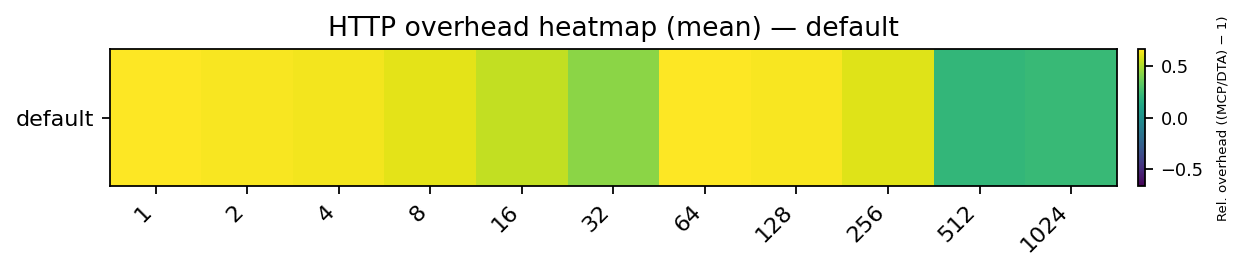

In [5]:
# --- One-row heatmap for DEFAULT profile (HTTP, mean) ---

import os
import numpy as np
import matplotlib.pyplot as plt

# assumes you've already run load_summaries() and built `df`
# and that compute_overhead_matrix(...) from your script is available

# Build the MCP/DTA overhead matrix for HTTP mean
mat_http_mean = compute_overhead_matrix(df, metric='meanMs', section='HTTP')

# Keep only the 'default' profile (single row)
if 'default' not in mat_http_mean.index:
    raise ValueError("Profile 'default' not found in results.")
row = mat_http_mean.loc[['default']]

# Ensure columns are sorted by numeric size (just in case)
row = row.reindex(sorted(row.columns, key=lambda x: float(x)), axis=1)

# Choose a symmetric color scale around 0 so green=positive, purple=negative stays comparable to your other plots
data = row.values.astype(float)
mx = np.nanmax(np.abs(data)) if data.size else 1.0
vmin, vmax = (-mx, mx) if mx > 0 else (0, 1)

# Plot the single-row heatmap
fig, ax = plt.subplots(figsize=(8, 1.8), dpi=160)
im = ax.imshow(data, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
ax.set_title('HTTP overhead heatmap (mean) — default')
ax.set_yticks([0])
ax.set_yticklabels(['default'])
ax.set_xticks(np.arange(row.shape[1]))
ax.set_xticklabels(list(row.columns), rotation=45, ha='right')

cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Rel. overhead ((MCP/DTA) − 1)', fontsize=6, labelpad=6)
plt.tight_layout()

plt.show()

# Optionally save
out_dir = './figures'
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'heatmap_http_overhead_mean_default.png'), bbox_inches='tight')


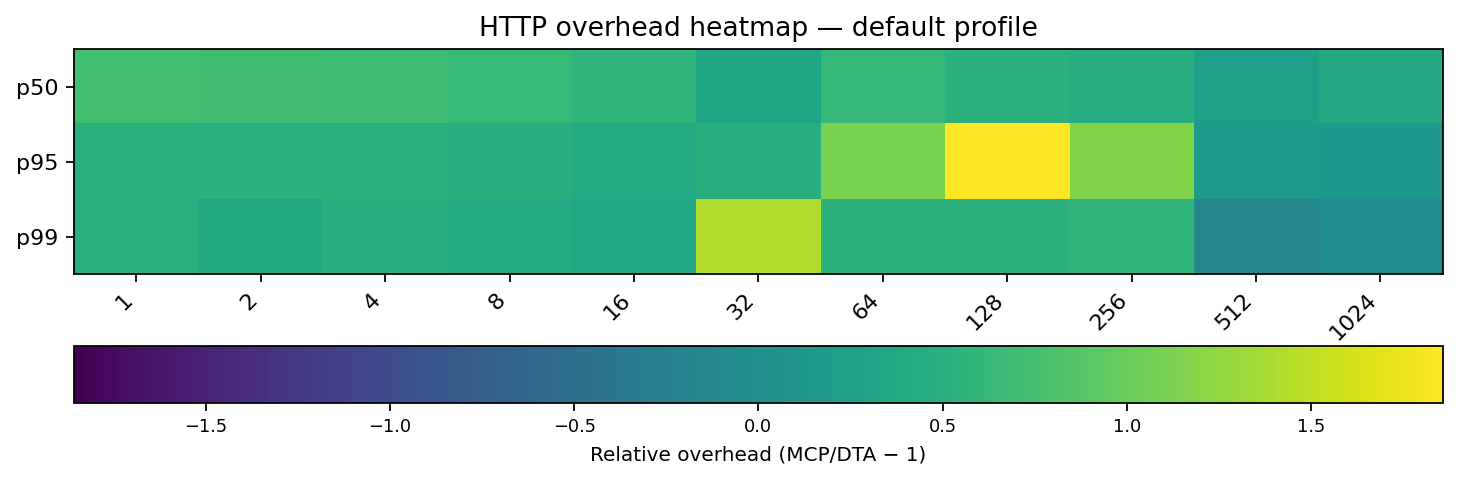

In [6]:
# Combined heatmap: default profile, HTTP overhead for p50/p95/p99
# Requires: df already loaded and compute_overhead_matrix available

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Build overhead matrices per metric (rows=profiles, cols=sizeKB)
mat_p50 = compute_overhead_matrix(df, metric='p50Ms', section='HTTP')
mat_p95 = compute_overhead_matrix(df, metric='p95Ms', section='HTTP')
mat_p99 = compute_overhead_matrix(df, metric='p99Ms', section='HTTP')

# Keep only the 'default' row, and ensure we have it
for m in (mat_p50, mat_p95, mat_p99):
    if 'default' not in m.index:
        raise ValueError("Profile 'default' not found in results.")

row_p50 = mat_p50.loc[['default']]
row_p95 = mat_p95.loc[['default']]
row_p99 = mat_p99.loc[['default']]

# Ensure consistent column ordering (numeric sort by sizeKB)
cols_sorted = sorted(set(row_p50.columns) | set(row_p95.columns) | set(row_p99.columns),
                     key=lambda x: float(x))
row_p50 = row_p50.reindex(cols_sorted, axis=1)
row_p95 = row_p95.reindex(cols_sorted, axis=1)
row_p99 = row_p99.reindex(cols_sorted, axis=1)

# Stack into a 3xN array; rows labeled by percentile
data = np.vstack([
    row_p50.values.astype(float),
    row_p95.values.astype(float),
    row_p99.values.astype(float)
])

# Symmetric color scale around zero across all three rows
mx = np.nanmax(np.abs(data)) if data.size else 1.0
vmin, vmax = (-mx, mx) if mx > 0 else (0, 1)

# Plot
fig, ax = plt.subplots(figsize=(9, 2.5), dpi=160, constrained_layout=True)
im = ax.imshow(data, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)

# Axes/labels
ax.set_title('HTTP overhead heatmap — default profile')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['p50', 'p95', 'p99'])
ax.set_xticks(np.arange(len(cols_sorted)))
ax.set_xticklabels([str(c) for c in cols_sorted], rotation=45, ha='right')
ax.set_xlabel('Payload size (KB)')

# Horizontal colorbar below the plot (fits better for short height)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="25%", pad=0.45)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Relative overhead (MCP/DTA − 1)', fontsize=9)
cbar.ax.tick_params(labelsize=8)

plt.show()

# Optional save
out_dir = './figures'
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'heatmap_http_overhead_default_p50_p95_p99.png'),
            bbox_inches='tight')


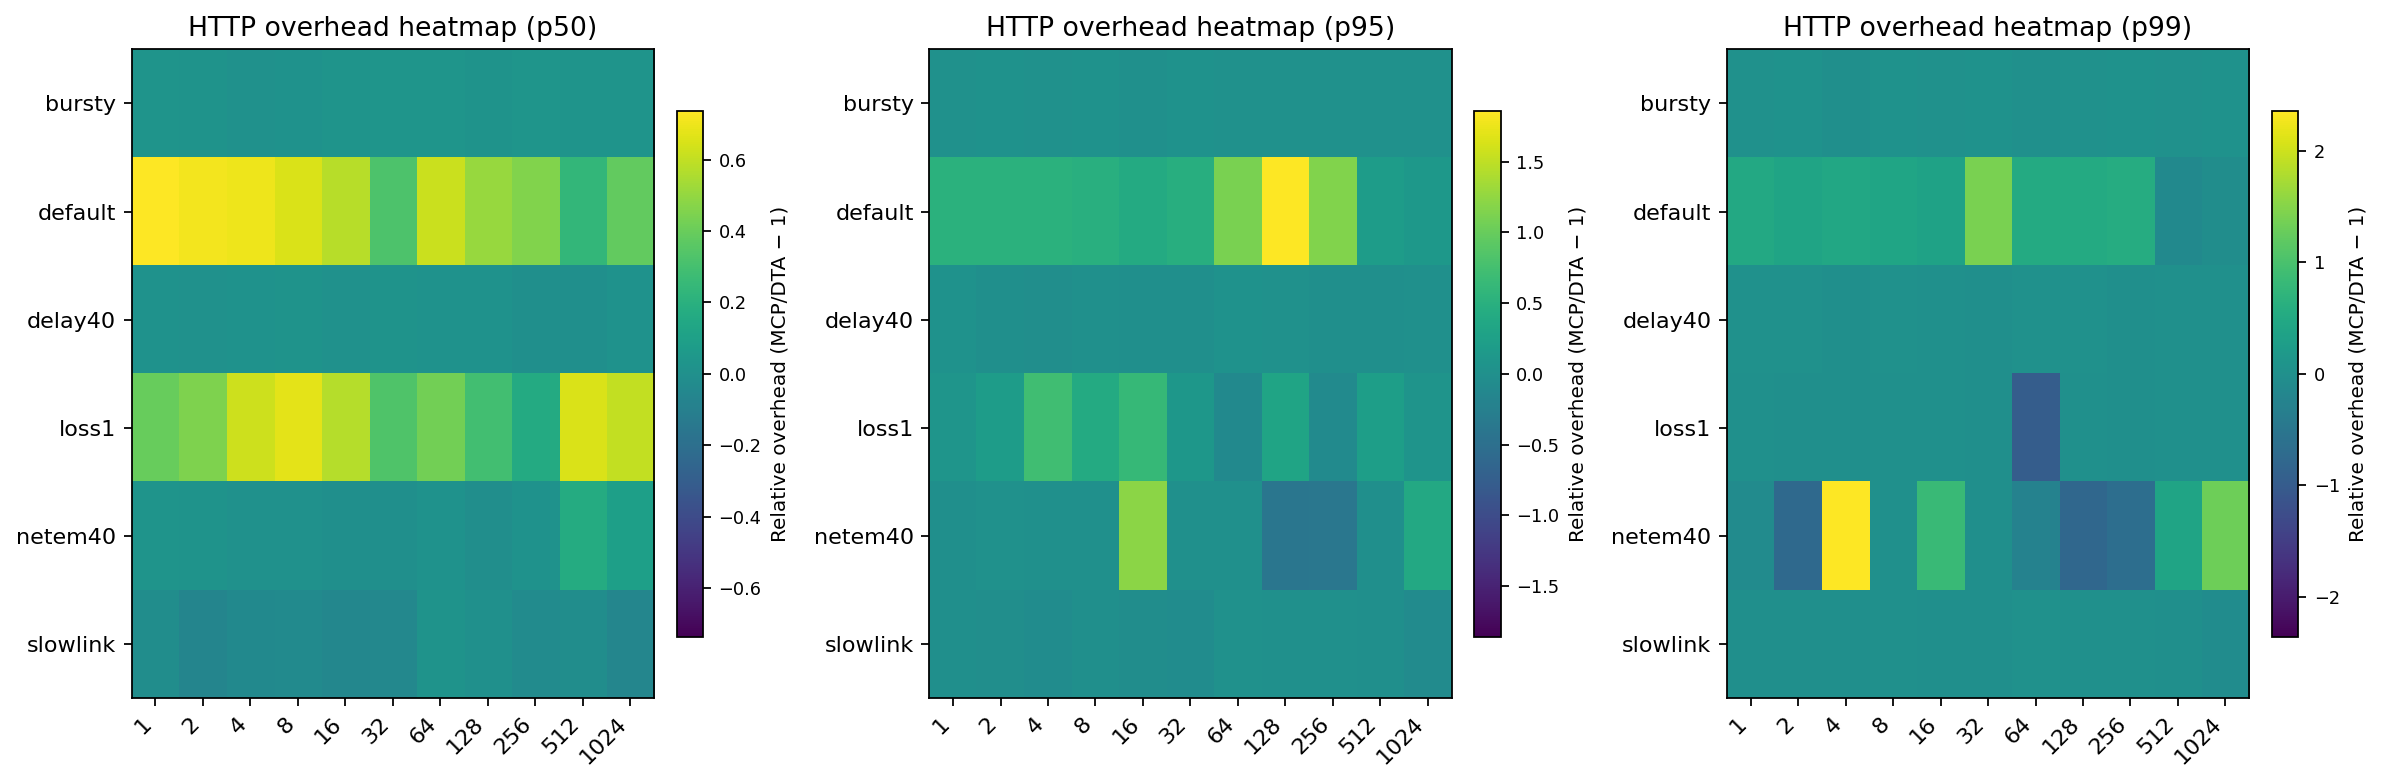

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helper: ensure we compare MCP vs DTA pairs only ---
def _ensure_pairs(sub):
    counts = sub.groupby(['profile','section','sizeKB'])['implementation'].nunique()
    keep = counts[counts == 2].index
    return sub.set_index(['profile','section','sizeKB']).loc[keep].reset_index()

# --- compute matrix of MCP/DTA overhead (MCP/DTA - 1) for a given metric ---
def _compute_overhead_matrix_local(df, metric='p50Ms', section='HTTP'):
    sub = df[(df['section']==section) & (df['implementation'].isin(['dta','mcp']))].copy()
    sub = _ensure_pairs(sub)
    piv = sub.pivot_table(index=['profile','sizeKB'], columns='implementation', values=metric).dropna()
    if set(['dta','mcp']).issubset(piv.columns):
        ratio = (piv['mcp'] / piv['dta']) - 1.0
    else:
        ratio = pd.Series([], dtype=float)
    mat = ratio.reset_index().pivot(index='profile', columns='sizeKB', values=0)
    if mat.shape[1] > 0:
        mat = mat.reindex(sorted(mat.columns, key=lambda x: float(x)), axis=1)
    return mat

# use existing compute_overhead_matrix if available
compute_overhead_matrix_fn = globals().get('compute_overhead_matrix', _compute_overhead_matrix_local)

# --- build matrices for p50/p95/p99 (HTTP) ---
mat_p50 = compute_overhead_matrix_fn(df, metric='p50Ms', section='HTTP')
mat_p95 = compute_overhead_matrix_fn(df, metric='p95Ms', section='HTTP')
mat_p99 = compute_overhead_matrix_fn(df, metric='p99Ms', section='HTTP')

# ensure same row and column ordering
profiles_order = mat_p50.index.tolist()
sizes_order    = mat_p50.columns.tolist()
mat_p95 = mat_p95.reindex(index=profiles_order, columns=sizes_order)
mat_p99 = mat_p99.reindex(index=profiles_order, columns=sizes_order)

# --- plot 3 subplots with individual colorbars ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=160)
mats = [mat_p50, mat_p95, mat_p99]
titles = ['HTTP overhead heatmap (p50)', 'HTTP overhead heatmap (p95)', 'HTTP overhead heatmap (p99)']

for ax, mat, title in zip(axes, mats, titles):
    data = mat.values.astype(float)
    mx = np.nanmax(np.abs(data)) if data.size else 1.0
    vmin, vmax = (-mx, mx) if mx > 0 else (0, 1)
    
    im = ax.imshow(data, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(list(mat.index))
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(list(mat.columns), rotation=45, ha='right')
    
    # add individual colorbar next to each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Relative overhead (MCP/DTA − 1)', fontsize=9)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# Optional save
out_dir = './figures'
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'fig_http_overhead_p50_p95_p99_split_cbar.png'), bbox_inches='tight')


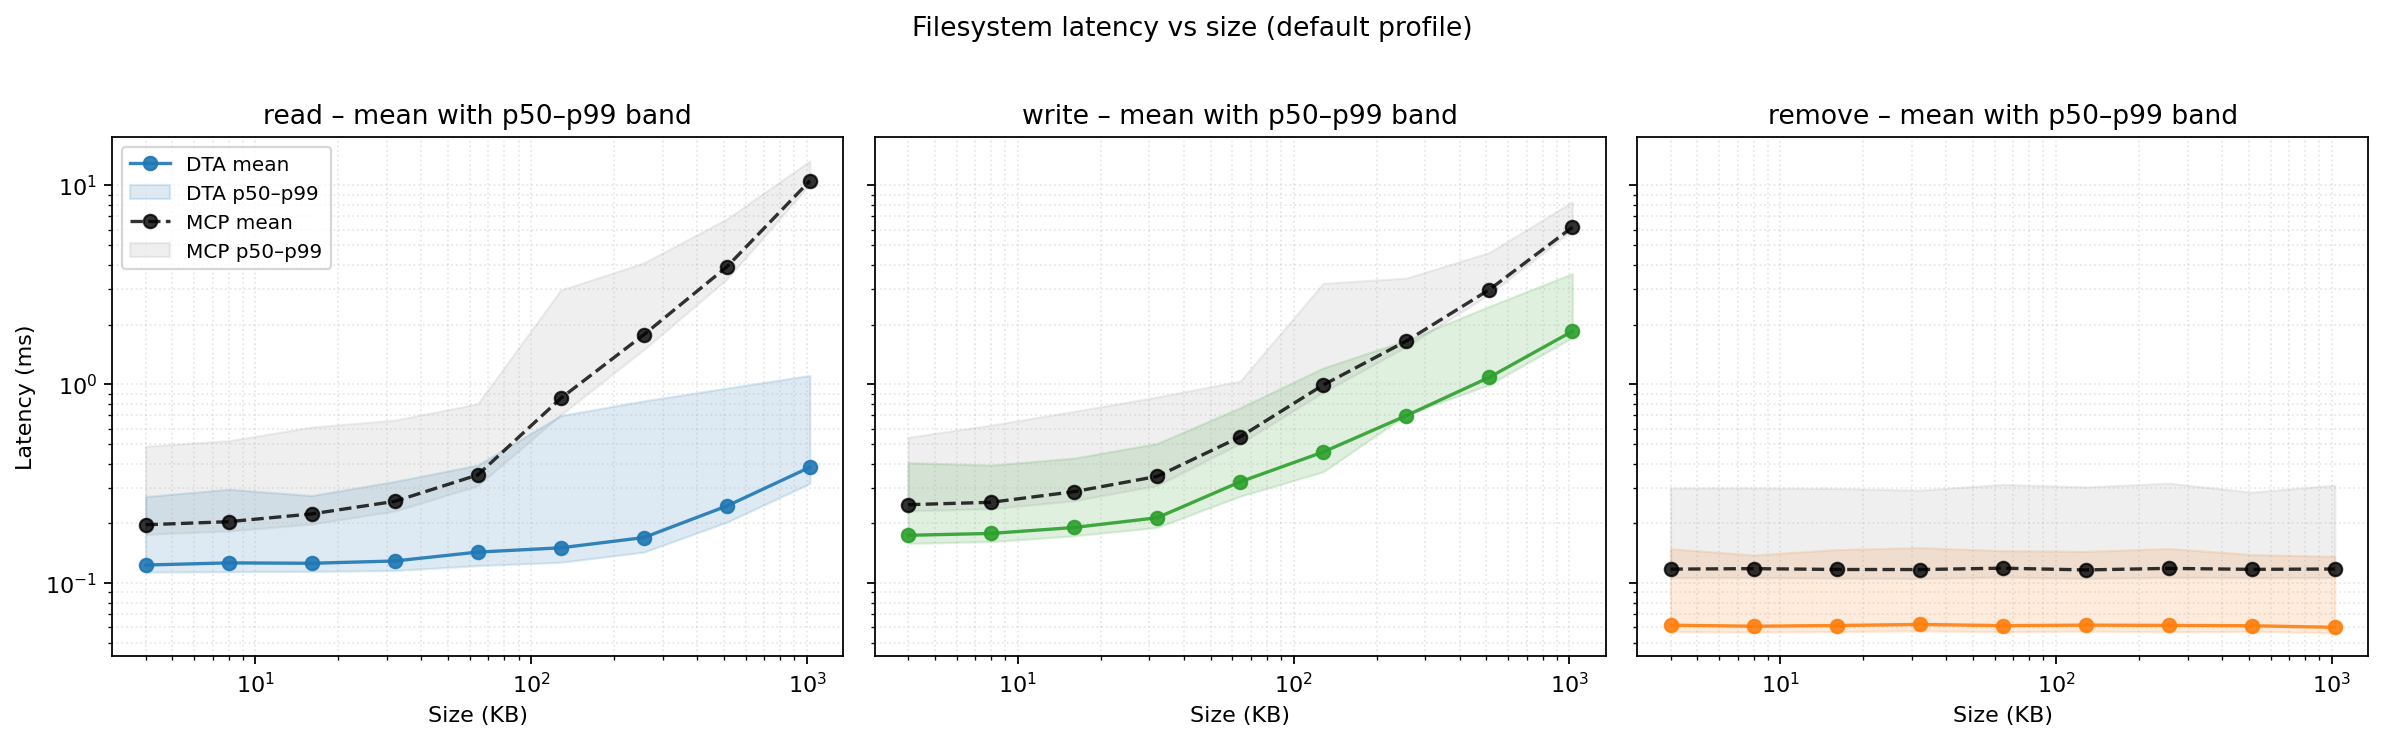

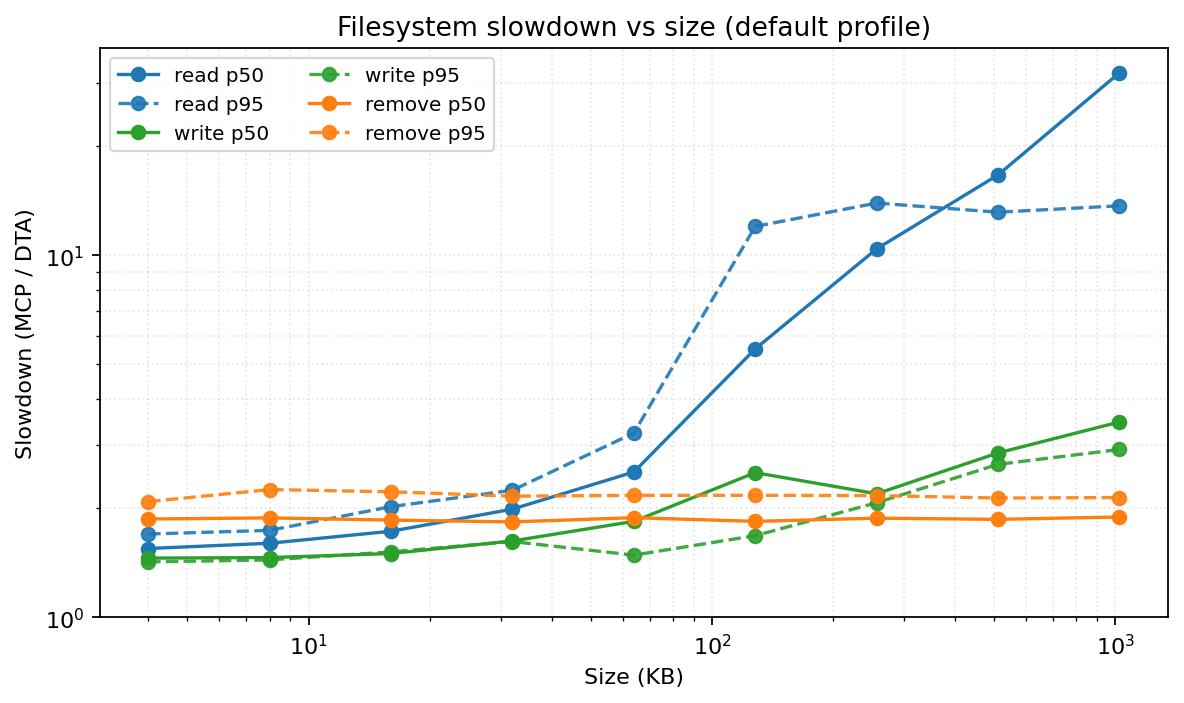

[READ] DTA fit: intercept = 0.108 ms, slope = 0.000198 ms/KB  (~0.20 µs/KB)
[READ] MCP fit: intercept = -0.272 ms, slope = 0.009426 ms/KB  (~9.43 µs/KB)


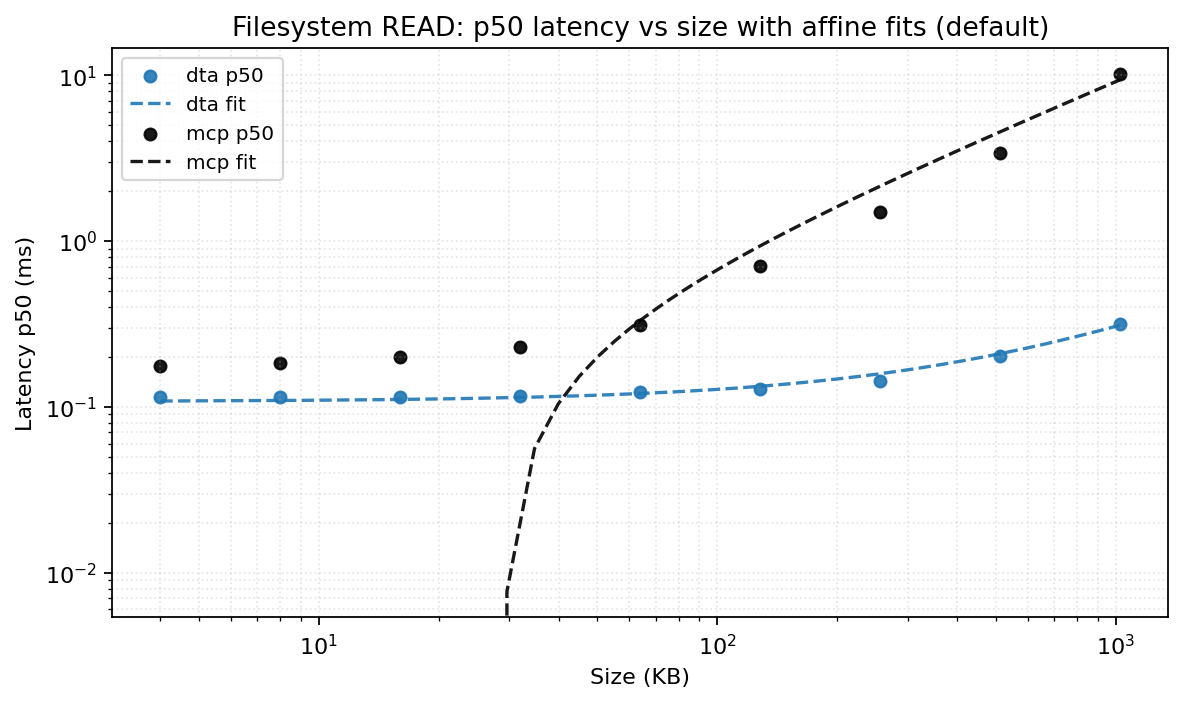

In [10]:
# FS figures for the paper (default profile only)
# Produces:
#   1) FS latency vs size (read/write/remove) with p50–p99 bands
#   2) Slowdown ratio (MCP/DTA) vs size for p50 and p95 (one compact panel)
#   3) Fixed-cost sanity check: affine fits for READ (DTA & MCP)
#
# Requirements: pandas, numpy, matplotlib

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Load default FS results
# -----------------------
paths_try = [
    "../results/default/bench.csv",
    "results/default/bench.csv",
]
csv_path = next((p for p in paths_try if os.path.exists(p)), None)
if not csv_path:
    raise FileNotFoundError(f"bench.csv not found at any of: {paths_try}")

df = pd.read_csv(csv_path)

# Normalize types & filter to FS/default
for col in ['sizeKB','meanMs','p50Ms','p95Ms','p99Ms','hz','iterations']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['implementation'] = df['implementation'].str.strip().str.lower()
df['section']        = df['section'].str.strip()

fs = df[(df['section'] == 'FS')]

# Helpers
def sizes_sorted(x):
    # ensure numeric sort even if columns are strings
    return sorted(x, key=lambda v: float(v))

def _ensure_pairs(sub):
    # Keep only cells where we have both dta and mcp for the same (operation, sizeKB)
    counts = sub.groupby(['operation','sizeKB'])['implementation'].nunique()
    keep = counts[counts == 2].index
    return sub.set_index(['operation','sizeKB']).loc[keep].reset_index()

# Palette per operation
OP_COLORS = {
    'read':  '#1f77b4',
    'write': '#2ca02c',
    'remove':'#ff7f0e',
}

# ============================================
# FIGURE 1: Latency vs size with percentile bands
# ============================================
ops = ['read','write','remove']
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), dpi=160, sharey=True)

for ax, op in zip(axes, ops):
    sub = fs[fs['operation'] == op].copy()
    sub = sub.sort_values('sizeKB')

    # DTA line + band
    s_dta = sub[sub['implementation'] == 'dta']
    if not s_dta.empty:
        ax.plot(s_dta['sizeKB'], s_dta['meanMs'], marker='o', label='DTA mean', color=OP_COLORS[op], alpha=0.9)
        ax.fill_between(s_dta['sizeKB'], s_dta['p50Ms'], s_dta['p99Ms'], alpha=0.15, color=OP_COLORS[op], label='DTA p50–p99')

    # MCP line + band (offset color slightly for clarity)
    s_mcp = sub[sub['implementation'] == 'mcp']
    if not s_mcp.empty:
        ax.plot(s_mcp['sizeKB'], s_mcp['meanMs'], marker='o', linestyle='--', label='MCP mean', color='black', alpha=0.8)
        ax.fill_between(s_mcp['sizeKB'], s_mcp['p50Ms'], s_mcp['p99Ms'], alpha=0.12, color='gray', label='MCP p50–p99')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Size (KB)')
    ax.set_title(f'{op} – mean with p50–p99 band')
    ax.grid(True, which='both', linestyle=':', alpha=0.3)

axes[0].set_ylabel('Latency (ms)')
# Single legend for the first axis (keeps the panel compact)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='best', fontsize=9)

plt.suptitle('Filesystem latency vs size (default profile)', y=1.02)
plt.tight_layout()
plt.show()

# ============================================
# FIGURE 2: Slowdown ratio (MCP / DTA) vs size
# - one compact panel
# - three operations (read/write/remove)
# - two metrics: p50 (solid) and p95 (dashed)
# ============================================
sub_pairs = _ensure_pairs(fs.copy())
if sub_pairs.empty:
    print("No DTA/MCP pairs found for FS; skipping slowdown ratio figure.")
else:
    # Build a joined table for easy ratios
    dta = sub_pairs[sub_pairs['implementation']=='dta'].set_index(['operation','sizeKB'])
    mcp = sub_pairs[sub_pairs['implementation']=='mcp'].set_index(['operation','sizeKB'])
    joined = dta.join(mcp, lsuffix='_dta', rsuffix='_mcp')
    joined = joined.reset_index().sort_values(['operation','sizeKB'])

    fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=160)

    for op in ops:
        j = joined[joined['operation'] == op]
        if j.empty:
            continue

        x = j['sizeKB'].values
        ratio_p50 = (j['p50Ms_mcp'] / j['p50Ms_dta']).values
        ratio_p95 = (j['p95Ms_mcp'] / j['p95Ms_dta']).values

        order = np.argsort(x)
        x = x[order]; ratio_p50 = ratio_p50[order]; ratio_p95 = ratio_p95[order]

        # Plot p50 as solid, p95 as dashed; color by operation
        ax.plot(x, ratio_p50, marker='o', color=OP_COLORS[op], label=f'{op} p50')
        ax.plot(x, ratio_p95, marker='o', linestyle='--', color=OP_COLORS[op], alpha=0.9, label=f'{op} p95')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Size (KB)')
    ax.set_ylabel('Slowdown (MCP / DTA)')
    ax.set_ylim(1, None)  # start at 1× for readability
    ax.grid(True, which='both', linestyle=':', alpha=0.3)
    ax.set_title('Filesystem slowdown vs size (default profile)')

    # De-duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    seen = {}
    new_h, new_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen[l] = True
            new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, ncol=2, fontsize=9, loc='best')

    plt.tight_layout()
    plt.show()

# ============================================
# FIGURE 3: Fixed-cost sanity check (READ only)
# - scatter p50 latency vs size for DTA & MCP
# - affine fit (y = a + b * sizeKB)
# - prints intercepts (ms) and slopes (ms/KB and µs/KB)
# ============================================
read_fs = fs[fs['operation']=='read'].copy().sort_values('sizeKB')
if read_fs.empty:
    print("No FS read data for default; skipping fixed-cost fit.")
else:
    fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=160)

    for impl, color in [('dta', OP_COLORS['read']), ('mcp', 'black')]:
        s = read_fs[read_fs['implementation']==impl]
        if s.empty:
            continue
        x = s['sizeKB'].values.astype(float)
        y = s['p50Ms'].values.astype(float)  # p50 for stability

        # Scatter
        ax.scatter(x, y, label=f'{impl} p50', alpha=0.9, s=28, color=color)

        # Fit affine model y = a + b*x (units: ms vs KB)
        # Use only finite points
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() >= 2:
            a, b = np.polyfit(x[mask], y[mask], 1)  # returns [b, a] actually
            b, a = a, b  # correct to (intercept a, slope b) if needed? Let's compute directly:
            # Careful: np.polyfit returns coefficients highest power first -> [slope, intercept]
            slope, intercept = np.polyfit(x[mask], y[mask], 1)

            # Plot fit line on the x-range
            xx = np.linspace(x.min(), x.max(), 200)
            yy = intercept + slope * xx
            ax.plot(xx, yy, linestyle='--', color=color, alpha=0.9, label=f'{impl} fit')

            # Print fit parameters
            print(f"[READ] {impl.upper()} fit: intercept = {intercept:.3f} ms, "
                  f"slope = {slope:.6f} ms/KB  (~{slope*1000:.2f} µs/KB)")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Size (KB)')
    ax.set_ylabel('Latency p50 (ms)')
    ax.grid(True, which='both', linestyle=':', alpha=0.3)
    ax.set_title('Filesystem READ: p50 latency vs size with affine fits (default)')
    ax.legend(fontsize=9, loc='best')

    plt.tight_layout()
    plt.show()
